# Answer Ranking Model using KoBERT

# 0. Import

In [2]:
# !pip install --upgrade tensorflow==2.7
# !pip install transformer
# !pip install kobert-transformers

import urllib.request
import pandas as pd

from matplotlib import pyplot as plt
import random

import torch
from kobert_transformers import get_kobert_model, get_distilkobert_model

from kobert_transformers import get_tokenizer

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

## 1. Data loading

In [3]:
# data download
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")

# data load
train_dataset = pd.read_csv('ChatBotData.csv')

# check data
print(f"전체 데이터셋 개수: {len(train_dataset)}")

전체 데이터셋 개수: 11823


# 2. Preprocessing

In [4]:
# Missing value check
train_dataset.replace("", float("NaN"), inplace=True)
print(train_dataset.isnull().values.any())

False


In [5]:
# Duplicated values check and remove
# for Question
train_dataset = train_dataset.drop_duplicates(['Q']).reset_index(drop=True)
print(f"필터링된 데이터셋 총 개수 : {len(train_dataset)}")

# for Answer
train_dataset = train_dataset.drop_duplicates(['A']).reset_index(drop=True)
print(f"필터링된 데이터셋 총 개수 : {len(train_dataset)}")

필터링된 데이터셋 총 개수 : 11662
필터링된 데이터셋 총 개수 : 7731


질문의 최대 길이 : 56
질문의 평균 길이 : 13.6732634846721


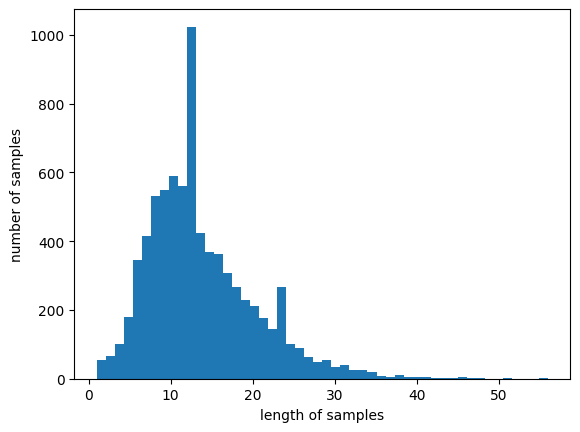

답변의 최대 길이 : 76
답변의 평균 길이 : 15.611563833915406


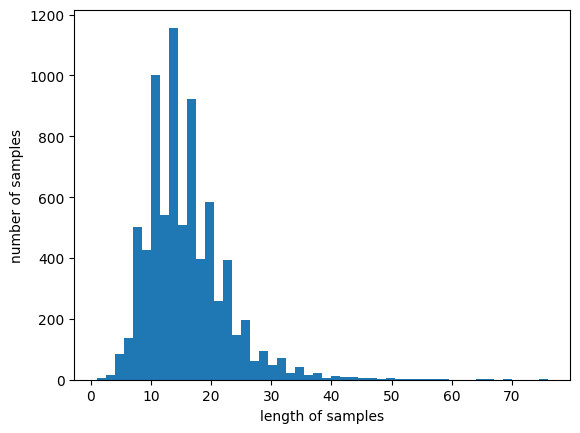

In [7]:
# Data distribution check
from matplotlib import pyplot as plt

question_list = list(train_dataset['Q'])
answer_list = list(train_dataset['A'])

# for Question
print('질문의 최대 길이 :',max(len(question) for question in question_list))
print('질문의 평균 길이 :',sum(map(len, question_list))/len(question_list))
plt.hist([len(question) for question in question_list], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# for Answer
print('답변의 최대 길이 :',max(len(answer) for answer in answer_list))
print('답변의 평균 길이 :',sum(map(len, answer_list))/len(answer_list))
plt.hist([len(answer) for answer in answer_list], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [9]:
# Answer candidate listing
print(f"question 개수: {len(question_list)}")
print(f"answer 개수: {len(answer_list)}")

response_candidates = random.sample(answer_list, 100)

response_candidates[:10]

question 개수: 7731
answer 개수: 7731


['잘 놀다 오세요.',
 '겉으로는 편하게 지낼 수 있을 거예요.',
 '완전 귀엽죠?',
 '당신은 누구보다 소중한 사람이에요.',
 '그녀의 마음을 확인했나봐요.',
 '진짜 이유를 말하지 못하는 사정이 있나봐요.',
 '이제 그만 잊으세요.',
 '이름, 직업 등 말고 온전히 자신으로 사는 거죠.',
 '기다리는 동안 많은 생각이 들었겠네요.',
 '가능합니다!']

# 3. KoBERT-Transformers loading

In [10]:
model = get_kobert_model()
model.eval()

input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
attention_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])
output = model(input_ids, attention_mask, token_type_ids)
output


BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.2461,  0.2428,  0.2590,  ..., -0.4861, -0.0731,  0.0756],
         [-0.2478,  0.2420,  0.2552,  ..., -0.4877, -0.0727,  0.0754],
         [-0.2472,  0.2420,  0.2561,  ..., -0.4874, -0.0733,  0.0765]],

        [[ 0.0768, -0.1234,  0.1534,  ..., -0.2518, -0.2571,  0.1602],
         [-0.2419, -0.2821,  0.1962,  ..., -0.0172, -0.2960,  0.3679],
         [ 0.0911, -0.1437,  0.3412,  ...,  0.2526, -0.1780,  0.2619]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.0903, -0.0444,  0.1579,  ...,  0.1010, -0.0819,  0.0529],
        [ 0.0742, -0.0116, -0.6845,  ...,  0.0024, -0.0447,  0.0122]],
       grad_fn=<TanhBackward0>), hidden_states=None, past_key_values=None, attentions=None, cross_attentions=None)

In [11]:
from kobert_transformers import get_tokenizer

tokenizer = get_tokenizer()
# %%
tokenizer.tokenize("[CLS] 한국어 모델을 공유합니다. [SEP]")
#%%
tokenizer.convert_tokens_to_ids(['[CLS]', '▁한국', '어', '▁모델', '을', '▁공유', '합니다', '.', '[SEP]'])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


[2, 4958, 6855, 2046, 7088, 1050, 7843, 54, 3]

# 4. Answer Ranking model implementation

In [12]:
def get_cls_token(sentence):
    model.eval()
    tokenized_sent = tokenizer(
      sentence,
      return_tensors="pt",
      truncation=True,
      add_special_tokens=True,
      max_length=128
    )
    input_ids = tokenized_sent['input_ids']
    attention_mask = tokenized_sent['attention_mask']
    token_type_ids = tokenized_sent['token_type_ids']

    with torch.no_grad():
        output = model(input_ids, attention_mask, token_type_ids)

    cls_output = output[1]
    cls_token = cls_output.detach().cpu().numpy()

    return cls_token

def predict(query, candidates):
  candidates_cls = []
  
  for cand in candidates:
    cand_cls = get_cls_token(cand)
    candidates_cls.append(cand_cls)
  
  candidates_cls = np.array(candidates_cls).squeeze(axis=1)

  queury_cls = get_cls_token(query)
  similarity_list = cosine_similarity(queury_cls, candidates_cls)

  target_idx = np.argmax(similarity_list)

  return candidates[target_idx]

In [13]:
# get_cls_token() test
query = '너 요즘 바빠?'
query_cls_hidden = get_cls_token(query)
print(query_cls_hidden)
print(query_cls_hidden.shape)

[[ 2.45257933e-02 -5.04535735e-02  2.37492636e-01  5.56507111e-02
  -2.82313049e-01  6.53344512e-01 -7.57842958e-01  1.01251751e-01
  -9.36002582e-02 -5.65410927e-02  1.83803827e-01 -2.38687992e-02
  -1.66099649e-02  1.06891729e-01  4.93002906e-02  1.18953228e-01
  -8.87609720e-01  1.08037494e-01 -1.43279508e-02 -4.42548171e-02
   2.50453968e-02 -2.60360129e-02  1.57189742e-02 -3.88896995e-04
   2.57271025e-02  1.39733270e-01 -2.52429128e-01 -1.13497496e-01
   5.75764596e-01 -1.95606016e-02  9.85265434e-01 -3.63530308e-01
  -5.28591797e-02 -9.86305848e-02 -9.31751847e-01 -5.56026220e-01
  -4.24075201e-02 -4.39448841e-02 -8.90622735e-01 -3.02542355e-02
  -3.89594696e-02  3.88101041e-02 -5.31252241e-03  7.69488335e-01
   3.42447490e-01  2.32722238e-02 -8.68956506e-01  1.71257765e-03
   8.40301931e-01 -3.75104129e-01 -3.62845987e-01  9.28677142e-01
   7.06579447e-01 -1.51405577e-02 -6.25408664e-02  4.52813983e-01
   1.16167963e-01  6.04886830e-01 -4.08327468e-02  4.54752780e-02
   4.75200

In [14]:
# prediction() test
sample_query = '너 요즘 바빠?'
sample_candidates = ['아니 별로 안바빠','바쁘면 바보','사자와 호랑이가 싸우면 누가 이길까', "내일은 과연 해가 뜰까"]

predicted_answer = predict(query, sample_candidates)

print(f"predicted_answer = {predicted_answer}")

predicted_answer = 아니 별로 안바빠


In [16]:
# answer evaluation
user_query = '너 요즘 바빠?'
predicted_answer = predict(query, response_candidates)

print(f"question = {user_query}")
print(f"predicted_answer = {predicted_answer}")

response_candidates = random.sample(answer_list, 100)
user_query = '나 요즘 너무 힘들어'
predicted_answer = predict(query, response_candidates)
print(f"question = {user_query}")
print(f"predicted_answer = {predicted_answer}")

question = 너 요즘 바빠?
predicted_answer = 어떻게든 참는게 좋을 거예요.
question = 나 요즘 너무 힘들어
predicted_answer = 속 쓰리겠어요.


In [17]:
# implement
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if len(sentence) == 0 :
        break
    predicted_answer = predict(sentence, response_candidates)
    print(f"Q: {sentence}")
    print(f"A: {predicted_answer}")
    print("\n")

Q: 야이 새꺄
A: 따뜻하게 사세요!


